# XGBoost and LightGBM

In this notebook, we try some more advanced tree-based models that are considered state-of-the-art solutions in ML research. Those include:

* XGBoost by DMLC (https://github.com/dmlc/xgboost)
* LightGBM by Microsoft (https://github.com/microsoft/LightGBM)

None of those solutions are natively implemented in Spark, although both XGBoost and LightGBM have a Spark implementation (XGBoost4J-Spark for XGBoost, available for Scala only, and MMLSpark for LightGBM, preinstalled in Azure-based Spark clusters). For simplicity, here we are going to use only the sequential versions of the two algorithms, available as Python packages.

In [1]:
!pip install xgboost > /dev/null
!pip install lightgbm > /dev/null

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [2]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## Input data parsing

In [3]:
trainData = pd.read_csv("trainingData.csv")
testData = pd.read_csv("testData.csv")
resultsDF = pd.DataFrame(columns=["Algorithm", "Features", "Metric", "Value"])

## Solution #1: only numerical features

In our first solution, we use only the numerical features exposed by our dataset (`NumBikesDiff-3`, `NumBikesDiff-2`, `NumBikesDiff-1`, `NumBikesDiff` and `NumBikes`) to predict the value of `NumBikesDiff+1`.

**XGBoost solution**

In [4]:
xgb = XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1).fit(trainData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes"
]], trainData["NumBikesDiff+1"])

In terms of feature importance, the XGBoost model appears to behave similarly to a classical decision tree, favoring the `NumBikesDiff` and `NumBikes` attributes. This is coherent with the classical approach for learning the tree followed by the XGBoost algorithm.

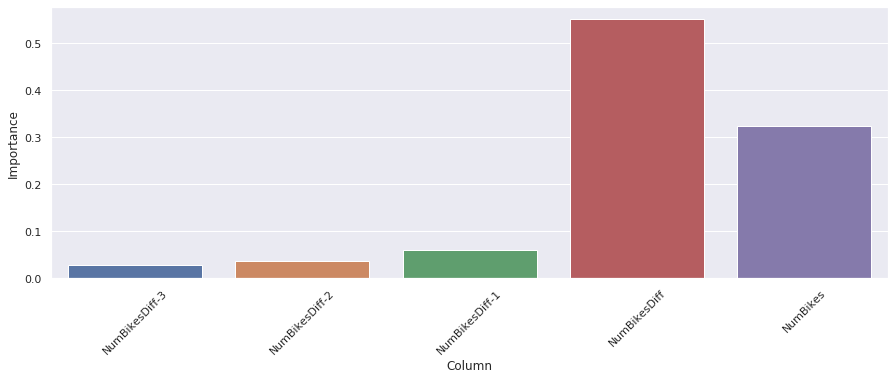

In [5]:
importanceDF = pd.DataFrame({
    "Column": ["NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes"],
    "Importance": xgb.feature_importances_
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=importanceDF, x="Column", y="Importance", ax=ax)
ax.set_xticklabels(labels=importanceDF["Column"], rotation=45);

In terms of evaluation metrics, this solution performs similar to the corresponding gradient-boosted tree.

In [6]:
rmse = mean_squared_error(testData["NumBikes+1"], testData["NumBikes"] + xgb.predict(testData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes"
]]), squared=False)
print("RMSE:", rmse)

r2 = r2_score(testData["NumBikes+1"], testData["NumBikes"] + xgb.predict(testData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes"
]]))
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Algorithm": "XGBoost", "Features": "Only numerical", "Metric": "RMSE", "Value": rmse},
    {"Algorithm": "XGBoost", "Features": "Only numerical", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4315656301471558
R2: 0.9668745994207976


**LightGBM solution**

In [7]:
lgbm = LGBMRegressor(random_state=42, n_jobs=-1).fit(trainData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes"
]], trainData["NumBikesDiff+1"])

LightGBM's leaf-wise approach for growing the tree is quite different from the classical, level-wise one. This is reflected in the obtained feature importances, which is much more well-distributed among the different attributes.

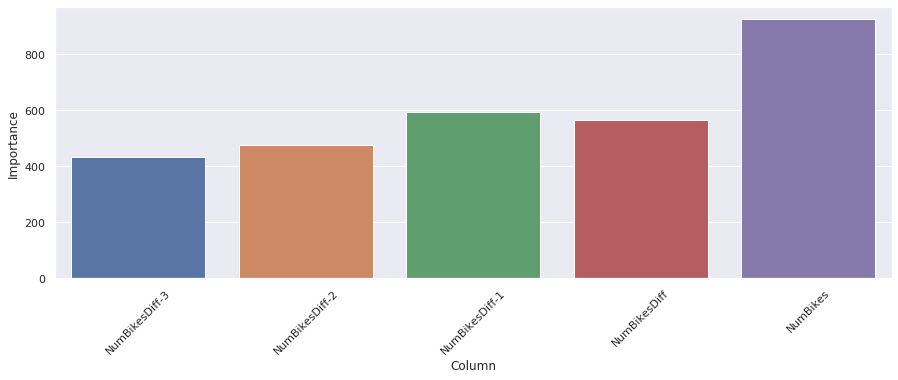

In [8]:
importanceDF = pd.DataFrame({
    "Column": ["NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes"],
    "Importance": lgbm.feature_importances_
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=importanceDF, x="Column", y="Importance", ax=ax)
ax.set_xticklabels(labels=importanceDF["Column"], rotation=45);

In terms of evaluation metrics, this solution performs slightly better than the corresponding XGBoost-based one.

In [9]:
rmse = mean_squared_error(testData["NumBikes+1"], testData["NumBikes"] + lgbm.predict(testData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes"
]]), squared=False)
print("RMSE:", rmse)

r2 = r2_score(testData["NumBikes+1"], testData["NumBikes"] + lgbm.predict(testData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes"
]]))
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Algorithm": "LightGBM", "Features": "Only numerical", "Metric": "RMSE", "Value": rmse},
    {"Algorithm": "LightGBM", "Features": "Only numerical", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.429525399314643
R2: 0.9669689510915338


## Solution #2: simple categorical features

In the second solution, we enlarge the feature space by adding the values categorical features (the hour, the day of the week, and the zone of the station) into the model. Note that in this case we do not need to previously encode our features (for example, using one-hot encoding): decision trees indeed do not regress directly on any features; rather, they use them to design proper split values, and in this sense it does not matter if the feature is numerical or categorical.

**XGBoost solution**

In [10]:
xgb = XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1).fit(trainData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
    "Hour", "DayOfWeek", "Zone"
]], trainData["NumBikesDiff+1"])

Also in this case, the algorithm seem to favor a few, very informative attributes which consequently get assigned a high importance.

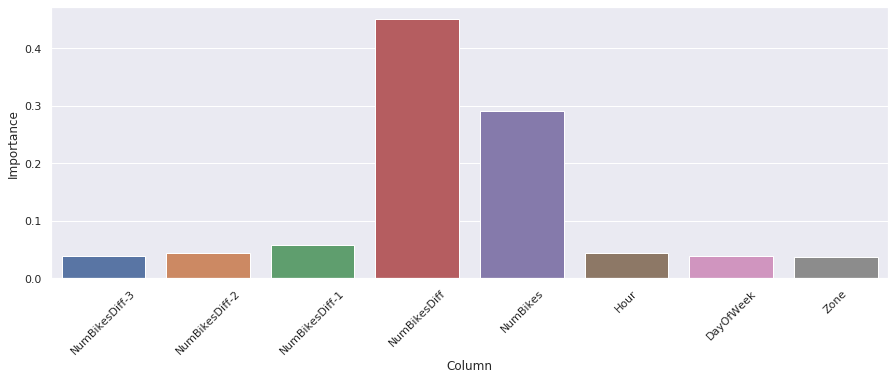

In [11]:
importanceDF = pd.DataFrame({
    "Column": [
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "Hour", "DayOfWeek", "Zone"
    ],
    "Importance": xgb.feature_importances_
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=importanceDF, x="Column", y="Importance", ax=ax)
ax.set_xticklabels(labels=importanceDF["Column"], rotation=45);

Test metrics result in a slightly improvement over the previous model.

In [12]:
rmse = mean_squared_error(testData["NumBikes+1"], testData["NumBikes"] + xgb.predict(testData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
    "Hour", "DayOfWeek", "Zone"
]]), squared=False)
print("RMSE:", rmse)

r2 = r2_score(testData["NumBikes+1"], testData["NumBikes"] + xgb.predict(testData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
    "Hour", "DayOfWeek", "Zone"
]]))
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Algorithm": "XGBoost", "Features": "Simple categorical", "Metric": "RMSE", "Value": rmse},
    {"Algorithm": "XGBoost", "Features": "Simple categorical", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.428299364720872
R2: 0.9670255850518734


**LightGBM solution**

In [13]:
lgbm = LGBMRegressor(random_state=42, n_jobs=-1).fit(trainData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
    "Hour", "DayOfWeek", "Zone"
]], trainData["NumBikesDiff+1"])

Again, LightGBM seems to favor the spread of feature importance on multiple attributes, with `Zone` surprisingly being ranked as the most informative one.

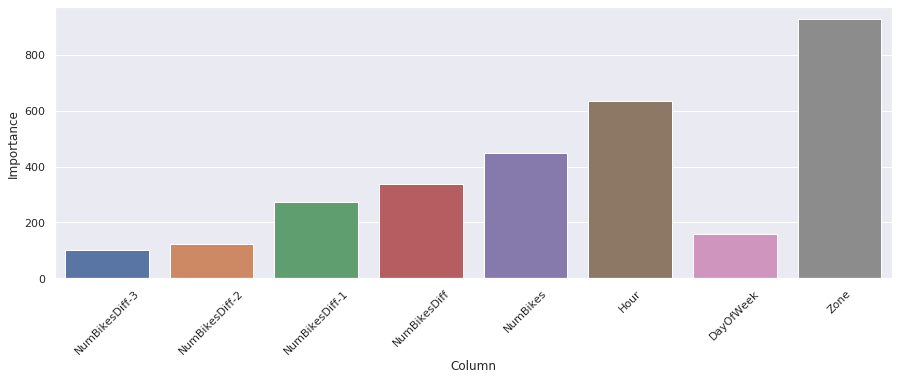

In [14]:
importanceDF = pd.DataFrame({
    "Column": [
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "Hour", "DayOfWeek", "Zone"
    ],
    "Importance": lgbm.feature_importances_
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=importanceDF, x="Column", y="Importance", ax=ax)
ax.set_xticklabels(labels=importanceDF["Column"], rotation=45);

This solution already achieves quite a significant improvement of our test metrics, basically in line with the full (but unoptimized) version of the GBT model.

In [15]:
rmse = mean_squared_error(testData["NumBikes+1"], testData["NumBikes"] + lgbm.predict(testData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
    "Hour", "DayOfWeek", "Zone"
]]), squared=False)
print("RMSE:", rmse)

r2 = r2_score(testData["NumBikes+1"], testData["NumBikes"] + lgbm.predict(testData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
    "Hour", "DayOfWeek", "Zone"
]]))
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Algorithm": "LightGBM", "Features": "Simple categorical", "Metric": "RMSE", "Value": rmse},
    {"Algorithm": "LightGBM", "Features": "Simple categorical", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4168959078165833
R2: 0.9675500146766053


## Solution #3: disjoint, effect-encoded categorical features

In the third solution, we use the effect-encoded version of our categorical features, considering only the "disjoint" ones (i.e., we consider separately the effect of the hour, day of the week, and zone of the station).

**XGBoost solution**

In [16]:
xgb = XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1).fit(trainData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
    "AvgByHour", "AvgByWeekday", "AvgByZone"
]], trainData["NumBikesDiff+1"])

In this model, the averaged features seem to capture some importance, but still they are very behind `NumBikesDiff` and `NumBikes`.

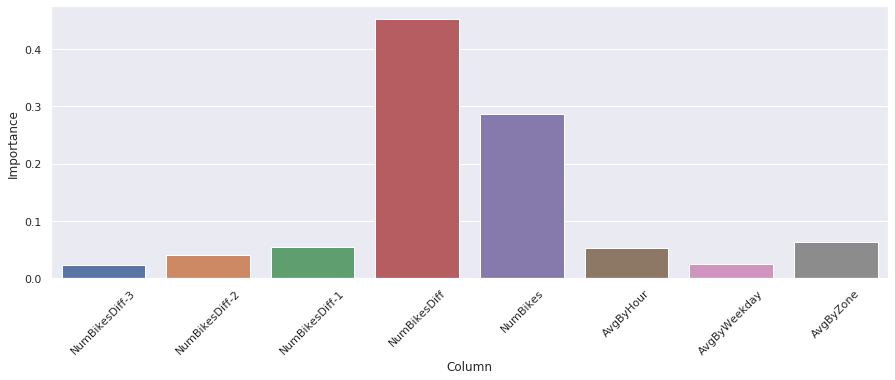

In [17]:
importanceDF = pd.DataFrame({
    "Column": [
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "AvgByHour", "AvgByWeekday", "AvgByZone"
    ],
    "Importance": xgb.feature_importances_
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=importanceDF, x="Column", y="Importance", ax=ax)
ax.set_xticklabels(labels=importanceDF["Column"], rotation=45);

The performance of this model is quite similar to the one fitted by the algorithm on the previous set of features, with only a slight improvement.

In [18]:
rmse = mean_squared_error(testData["NumBikes+1"], testData["NumBikes"] + xgb.predict(testData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
    "AvgByHour", "AvgByWeekday", "AvgByZone"
]]), squared=False)
print("RMSE:", rmse)

r2 = r2_score(testData["NumBikes+1"], testData["NumBikes"] + xgb.predict(testData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
    "AvgByHour", "AvgByWeekday", "AvgByZone"
]]))
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Algorithm": "XGBoost", "Features": "Disjoint effect", "Metric": "RMSE", "Value": rmse},
    {"Algorithm": "XGBoost", "Features": "Disjoint effect", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4262452115870505
R2: 0.9671203632086612


**LightGBM solution**

In [19]:
lgbm = LGBMRegressor(random_state=42, n_jobs=-1).fit(trainData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
    "AvgByHour", "AvgByWeekday", "AvgByZone"
]], trainData["NumBikesDiff+1"])

As opposed to XGBoost, LightGBM seems to favor also in this case the information carried by categorical attributes, with the most informative ones being `AvgByZone` and `AvgByHour`.

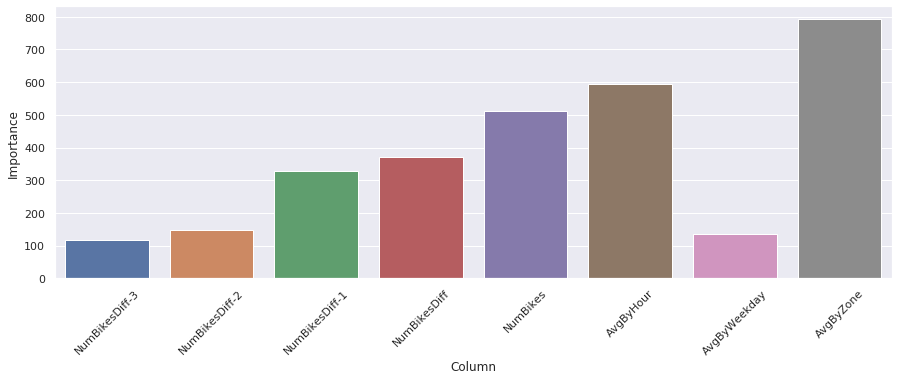

In [20]:
importanceDF = pd.DataFrame({
    "Column": [
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "AvgByHour", "AvgByWeekday", "AvgByZone"
    ],
    "Importance": lgbm.feature_importances_
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=importanceDF, x="Column", y="Importance", ax=ax)
ax.set_xticklabels(labels=importanceDF["Column"], rotation=45);

Still, this feature combination results in lower performance with respect to the previous LightGBM solution.

In [21]:
rmse = mean_squared_error(testData["NumBikes+1"], testData["NumBikes"] + lgbm.predict(testData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
    "AvgByHour", "AvgByWeekday", "AvgByZone"
]]), squared=False)
print("RMSE:", rmse)

r2 = r2_score(testData["NumBikes+1"], testData["NumBikes"] + lgbm.predict(testData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
    "AvgByHour", "AvgByWeekday", "AvgByZone"
]]))
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Algorithm": "LightGBM", "Features": "Disjoint effect", "Metric": "RMSE", "Value": rmse},
    {"Algorithm": "LightGBM", "Features": "Disjoint effect", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4192976338399796
R2: 0.9674399119839188


## Solution #4: combined, effect-encoded categorical features

Here, we consider a solution in which we use all the available numerical features, plus the joint average computed considering all the categorical values at once.

**XGBoost solution**

In [22]:
xgb = XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1).fit(trainData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes", "AvgCombined"
]], trainData["NumBikesDiff+1"])

In terms of feature importance, this models still favors only a few attributes, with a notable information gain obtained by `AvgCombined` (second highest).

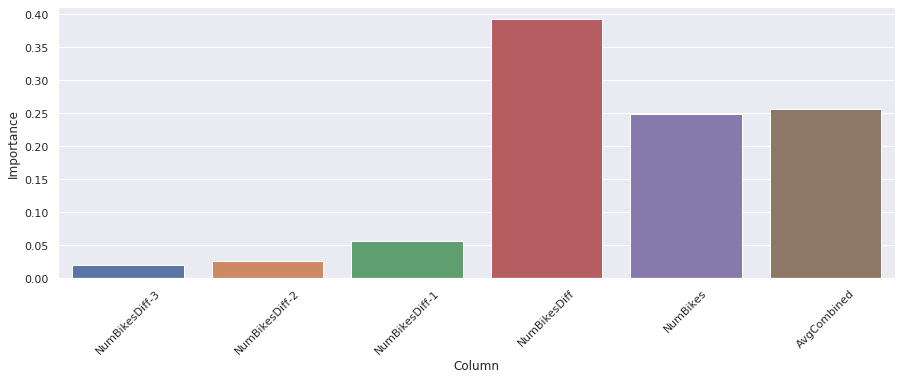

In [23]:
importanceDF = pd.DataFrame({
    "Column": ["NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes", "AvgCombined"],
    "Importance": xgb.feature_importances_
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=importanceDF, x="Column", y="Importance", ax=ax)
ax.set_xticklabels(labels=importanceDF["Column"], rotation=45);

This solution achieves another significant improvement over the last XGBoost-based one, performing on par with the last LightGBM model.

In [24]:
rmse = mean_squared_error(testData["NumBikes+1"], testData["NumBikes"] + xgb.predict(testData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes", "AvgCombined"
]]), squared=False)
print("RMSE:", rmse)

r2 = r2_score(testData["NumBikes+1"], testData["NumBikes"] + xgb.predict(testData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes", "AvgCombined"
]]))
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Algorithm": "XGBoost", "Features": "Combined effect", "Metric": "RMSE", "Value": rmse},
    {"Algorithm": "XGBoost", "Features": "Combined effect", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.419869932549417
R2: 0.967413648495854


**LightGBM solution**

In [25]:
lgbm = LGBMRegressor(random_state=42, n_jobs=-1).fit(trainData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes", "AvgCombined"
]], trainData["NumBikesDiff+1"])

This LightGBM-based model spreads feature importance very evenly across the different attributes, with the largest contribution given again by `AvgCombined`.

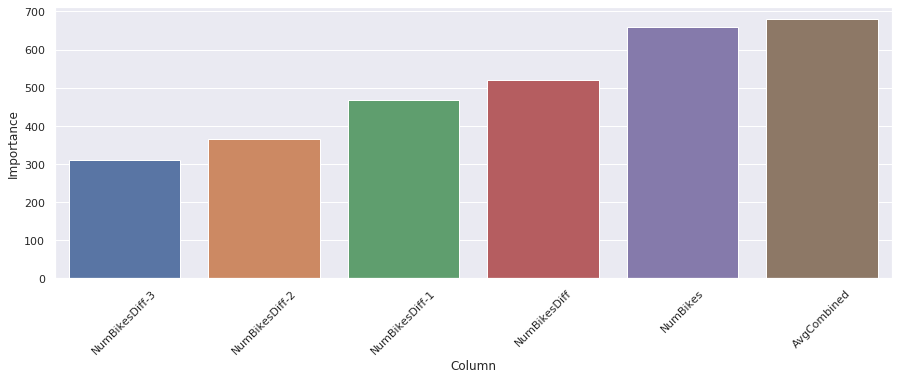

In [26]:
importanceDF = pd.DataFrame({
    "Column": ["NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes", "AvgCombined"],
    "Importance": lgbm.feature_importances_
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=importanceDF, x="Column", y="Importance", ax=ax)
ax.set_xticklabels(labels=importanceDF["Column"], rotation=45);

As for its performance, this solution achieves only a slight improvement over the previous one if we consider our test metrics.

In [27]:
rmse = mean_squared_error(testData["NumBikes+1"], testData["NumBikes"] + lgbm.predict(testData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes", "AvgCombined"
]]), squared=False)
print("RMSE:", rmse)

r2 = r2_score(testData["NumBikes+1"], testData["NumBikes"] + lgbm.predict(testData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes", "AvgCombined"
]]))
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Algorithm": "LightGBM", "Features": "Combined effect", "Metric": "RMSE", "Value": rmse},
    {"Algorithm": "LightGBM", "Features": "Combined effect", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.417430290129749
R2: 0.9675255330359344


## Solution #5: putting all together

Finally, we test a solution in which all the aforementioned features are fed to the learning algorithm.

**XGBoost solution**

In [28]:
xgb = XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1).fit(trainData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
    "Hour", "DayOfWeek", "Zone",
    "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
]], trainData["NumBikesDiff+1"])

The addition of the other variables in the model does not seem to affect much the distribution of feature importance, with `NumBikesDiff`, `AvgCombined` and `NumBikes` accounting for 70% of the total information gain.

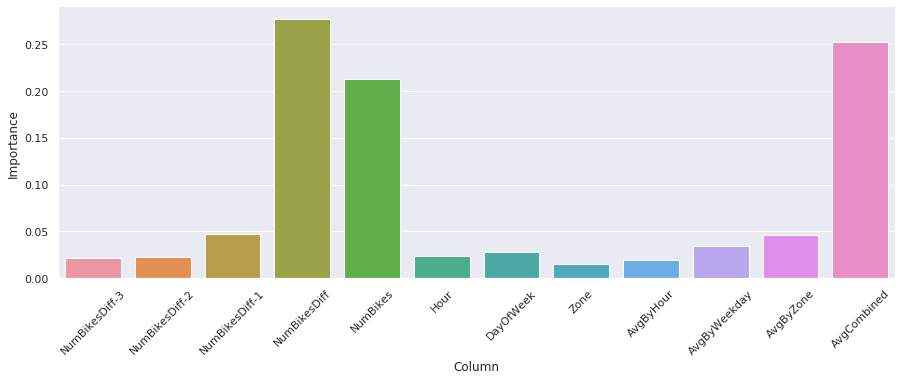

In [29]:
importanceDF = pd.DataFrame({
    "Column": [
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "Hour", "DayOfWeek", "Zone",
        "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
    ],
    "Importance": xgb.feature_importances_
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=importanceDF, x="Column", y="Importance", ax=ax)
ax.set_xticklabels(labels=importanceDF["Column"], rotation=45);

Consequently, only a small performance improvement is recorded by this model with respect to the previous one.

In [30]:
rmse = mean_squared_error(testData["NumBikes+1"], testData["NumBikes"] + xgb.predict(testData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
    "Hour", "DayOfWeek", "Zone",
    "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
]]), squared=False)
print("RMSE:", rmse)

r2 = r2_score(testData["NumBikes+1"], testData["NumBikes"] + xgb.predict(testData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
    "Hour", "DayOfWeek", "Zone",
    "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
]]))
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Algorithm": "XGBoost", "Features": "All", "Metric": "RMSE", "Value": rmse},
    {"Algorithm": "XGBoost", "Features": "All", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.417406934959475
R2: 0.9675266031985551


**LightGBM solution**

In [31]:
lgbm = LGBMRegressor(random_state=42, n_jobs=-1).fit(trainData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
    "Hour", "DayOfWeek", "Zone",
    "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
]], trainData["NumBikesDiff+1"])

As opposed to XGBoost, the LightGBM solution actually seems to favor the usage of more features, with importance distributed almost evenly across many of them.

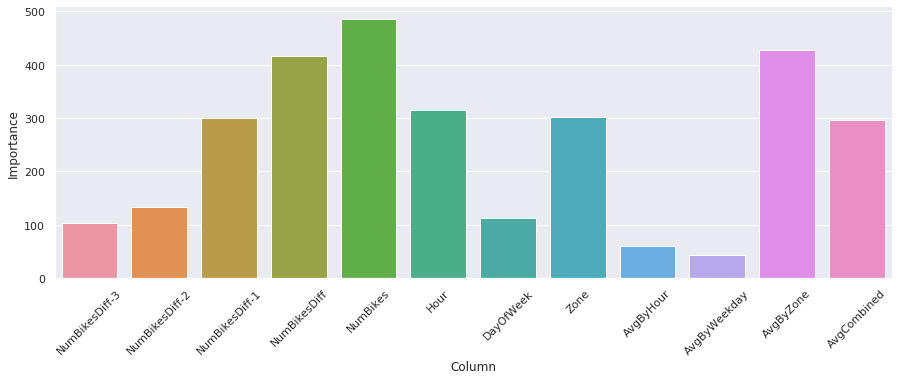

In [32]:
importanceDF = pd.DataFrame({
    "Column": [
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "Hour", "DayOfWeek", "Zone",
        "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
    ],
    "Importance": lgbm.feature_importances_
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=importanceDF, x="Column", y="Importance", ax=ax)
ax.set_xticklabels(labels=importanceDF["Column"], rotation=45);

Consequently, this model achieves a good improvement in test set metrics over the previous one.

In [33]:
rmse = mean_squared_error(testData["NumBikes+1"], testData["NumBikes"] + lgbm.predict(testData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
    "Hour", "DayOfWeek", "Zone",
    "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
]]), squared=False)
print("RMSE:", rmse)

r2 = r2_score(testData["NumBikes+1"], testData["NumBikes"] + lgbm.predict(testData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
    "Hour", "DayOfWeek", "Zone",
    "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
]]))
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Algorithm": "LightGBM", "Features": "All", "Metric": "RMSE", "Value": rmse},
    {"Algorithm": "LightGBM", "Features": "All", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4113938899575804
R2: 0.9678015416212588


## Hyperparameter optimization

For solution #5, we run an optimization procedure to determine the best values for the parameters of the regression models, so to increase even further their performance. To do so, we used the parameter grid defined in the cells below, in which we tested different values of some of the most important parameters of the two algorithms using scikit-learn's `GridSearchCV`. For uniformity with Spark, also here we used a 3-fold cross-validation.

**Warning**: running this cross-validation procedure requires ~3 hours. Do it only if necessary.

**XGBoost solution**

In [34]:
xgbCV = GridSearchCV(
    estimator=XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1),
    param_grid={
        "n_estimators": [100, 300],
        "max_depth": [5, 10],
        "learning_rate": [0.1, 0.25],
        "gamma": [0, 0.5],
        "min_child_weight": [1, 2],
        "subsample": [1, 0.75],
        "colsample_bytree": [1, 0.75]
    },
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=3
).fit(trainData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
    "Hour", "DayOfWeek", "Zone",
    "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
]], trainData["NumBikesDiff+1"])

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed: 54.9min
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed: 132.1min
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed: 197.0min finished


The overall best model is characterized by the parameters below.

In [35]:
print("Best model params:")
print("\n".join([f"- {x[0]}: {x[1]}" for x in xgbCV.best_params_.items()]))

Best model params:
- colsample_bytree: 0.75
- gamma: 0.5
- learning_rate: 0.1
- max_depth: 10
- min_child_weight: 2
- n_estimators: 100
- subsample: 1


With respect to the unoptimized case, this model seems to penalize the `AvgCombined` and `NumBikes` attributes, favoring instead `NumBikesDiff`. The other features all provide almost the same contribution to the information gain, around 5%.

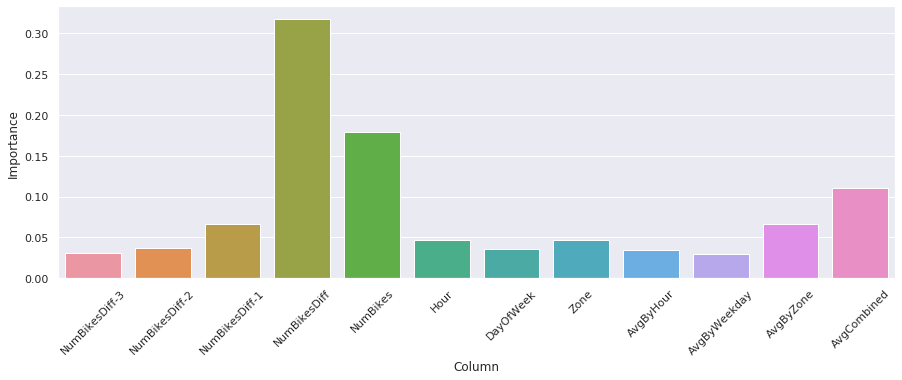

In [36]:
importanceDF = pd.DataFrame({
    "Column": [
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "Hour", "DayOfWeek", "Zone",
        "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
    ],
    "Importance": xgbCV.best_estimator_.feature_importances_
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=importanceDF, x="Column", y="Importance", ax=ax)
ax.set_xticklabels(labels=importanceDF["Column"], rotation=45);

In terms of evaluation metrics, this solution present a good improvement over the unoptimized case, and outperforms the best Spark GBT-based model.

In [37]:
rmse = mean_squared_error(testData["NumBikes+1"], testData["NumBikes"] + xgbCV.predict(testData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
    "Hour", "DayOfWeek", "Zone",
    "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
]]), squared=False)
print("RMSE:", rmse)

r2 = r2_score(testData["NumBikes+1"], testData["NumBikes"] + xgbCV.predict(testData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
    "Hour", "DayOfWeek", "Zone",
    "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
]]))
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Algorithm": "XGBoost", "Features": "All (CV)", "Metric": "RMSE", "Value": rmse},
    {"Algorithm": "XGBoost", "Features": "All (CV)", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4075712428545188
R2: 0.967975719310193


**LightGBM solution**

In [38]:
lgbmCV = GridSearchCV(
    estimator=LGBMRegressor(random_state=42, n_jobs=-1),
    param_grid={
        "n_estimators": [100, 300],
        "learning_rate": [0.1, 0.25],
        "num_leaves": [31, 127],
        "class_weight": [None, "balanced"],
        "min_child_samples": [20, 100],
        "subsample": [1, 0.75],
        "colsample_bytree": [1, 0.75]
    },
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=3
).fit(trainData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
    "Hour", "DayOfWeek", "Zone",
    "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
]], trainData["NumBikesDiff+1"])

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:  8.5min finished


The overall best model is characterized by the parameters below.

In [39]:
print("Best model params:")
print("\n".join([f"- {x[0]}: {x[1]}" for x in lgbmCV.best_params_.items()]))

Best model params:
- class_weight: None
- colsample_bytree: 0.75
- learning_rate: 0.1
- min_child_samples: 100
- n_estimators: 300
- num_leaves: 127
- subsample: 1


With respect to XGBoost's case, the optimization procedure for LightGBM requires an impressively reduced amount of time (8.5 vs 195.8 minutes) and produces a model where the information gain is very well-distributed among the different features, as shown below.

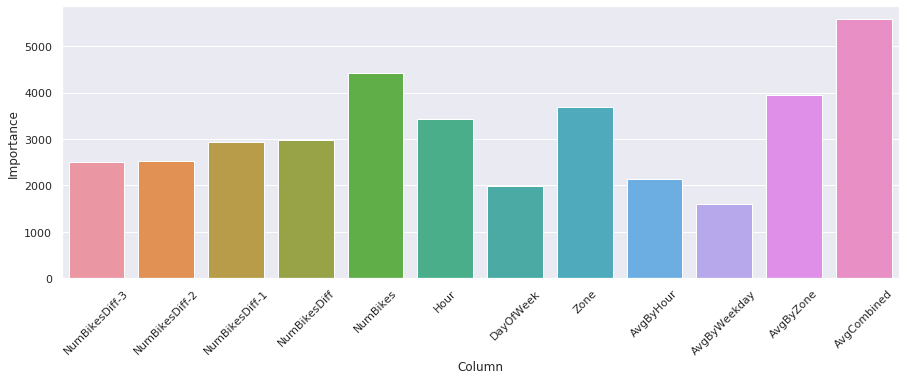

In [40]:
importanceDF = pd.DataFrame({
    "Column": [
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "Hour", "DayOfWeek", "Zone",
        "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
    ],
    "Importance": lgbmCV.best_estimator_.feature_importances_
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=importanceDF, x="Column", y="Importance", ax=ax)
ax.set_xticklabels(labels=importanceDF["Column"], rotation=45);

The resulting model results to be the best overall, improving ever so slightly on XGBoost's performance (but at a very reduced computational cost).

In [41]:
rmse = mean_squared_error(testData["NumBikes+1"], testData["NumBikes"] + lgbmCV.predict(testData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
    "Hour", "DayOfWeek", "Zone",
    "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
]]), squared=False)
print("RMSE:", rmse)

r2 = r2_score(testData["NumBikes+1"], testData["NumBikes"] + lgbmCV.predict(testData[[
    "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
    "Hour", "DayOfWeek", "Zone",
    "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
]]))
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Algorithm": "LightGBM", "Features": "All (CV)", "Metric": "RMSE", "Value": rmse},
    {"Algorithm": "LightGBM", "Features": "All (CV)", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4070748685379177
R2: 0.9679983017942942


## Comparison of the results

The two graphs below summarize the evolution of the RMSE and R2 metrics for the different sets of features tested.

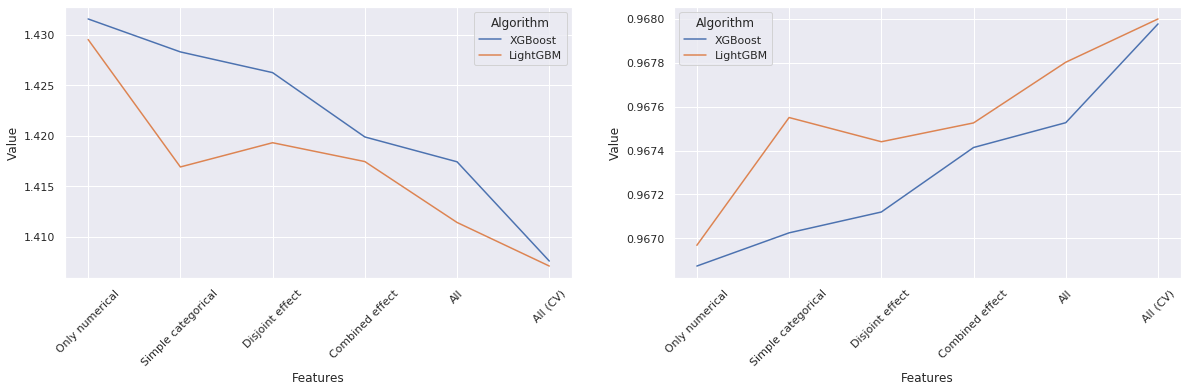

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.lineplot(data=resultsDF[resultsDF["Metric"] == "RMSE"], x="Features", y="Value", hue="Algorithm", ax=ax[0])
sns.lineplot(data=resultsDF[resultsDF["Metric"] == "R2"], x="Features", y="Value", hue="Algorithm", ax=ax[1])
ax[0].set_xticklabels(labels=resultsDF["Features"].unique(), rotation=45)
ax[1].set_xticklabels(labels=resultsDF["Features"].unique(), rotation=45);